<a href="https://colab.research.google.com/github/Guerouan/Handwriting-digits-recognition-Shap-explainability-/blob/master/hand_writing_digits_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import pandas as pd
import gzip
import numpy as np
conv = False

import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
%config InlineBackend.figure_format = 'svg'

**importing and extracting data**

In [0]:
#! git clone https://github.com/Guerouan/Handwriting-digits-recognition-Shap-explainability-
  
#path ='Handwriting-digits-recognition-Shap-explainability-/'
#from tensorflow.contrib.learn.python.learn.datasets.mnist import extract_images, extract_labels

#with open(path + 'train-images-idx3-ubyte.gz', 'rb') as f:
#  train_images = extract_images(f)
#with open(path + 'train-labels-idx1-ubyte.gz', 'rb') as f:
#  train_labels = extract_labels(f)

#with open(path + 't10k-images-idx3-ubyte.gz', 'rb') as f:
#  test_images = extract_images(f)
#with open(path + 't10k-labels-idx1-ubyte.gz', 'rb') as f:
#  test_labels = extract_labels(f)

**Simple Solution for cloud puposes**

In [0]:
from tensorflow.keras.datasets import mnist
img_rows, img_cols = 28, 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()

8


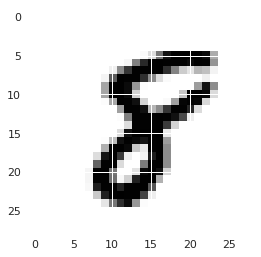

In [114]:
%matplotlib inline
import matplotlib.pyplot as plt

image_index = 777 # You may select anything up to 60,000
print(y_train[image_index]) # The label is 8
plt.imshow(x_train[image_index], cmap='Greys')

**Exploration Later**

data repartition

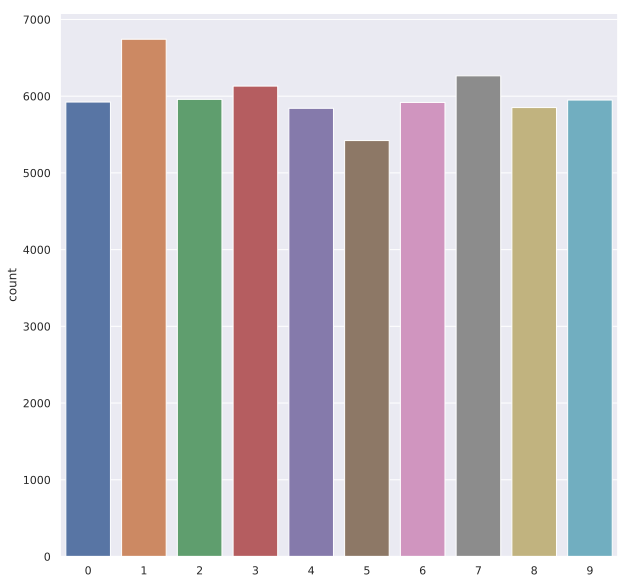

In [176]:
sns.set(style="darkgrid")
ax = sns.countplot(x=y_train)

**pca et t-sne**

In [0]:
import pandas as pd
data = x_train.reshape(x_train.shape[0], img_rows*img_cols)
data = pd.DataFrame(data)
data['label']= y_train

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components = 80)
X_pca = pca.fit_transform(data)

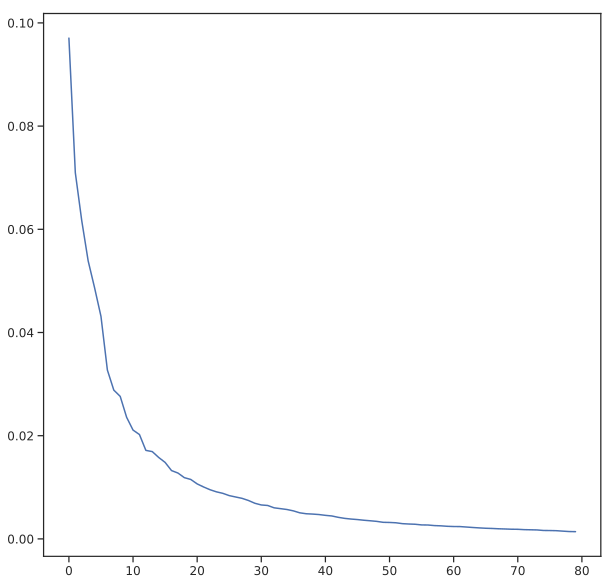

In [174]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

In [175]:
plt.boxplot(X_pca[:,0:80])
plt.show()

In [167]:
X_pca

array([[ 123.93332698, -312.66430642,  -24.5199696 , ...,  155.01425011,
        -137.74470507, -100.21618659],
       [1011.72462209, -294.87378969,  596.3393018 , ...,   52.47367895,
        -356.15504053,  -80.70813605],
       [ -51.85060576,  392.16193979, -188.50192307, ...,  145.14435903,
          35.44380722, -294.64776222],
       ...,
       [-178.05566299,  160.08640125, -257.61365057, ..., -178.22703516,
        -194.43965618, -336.27832188],
       [ 130.6063019 ,   -5.60083654,  513.86080192, ..., -281.58763366,
        -121.3554909 ,   59.4190199 ],
       [-173.43816993,  -24.71515934,  556.01705072, ..., -175.10188904,
         -51.4372949 ,   36.99778955]])

In [0]:
tsne = TSNE()
X_tsne = tsne.fit_transform(X_pca[:10000])  

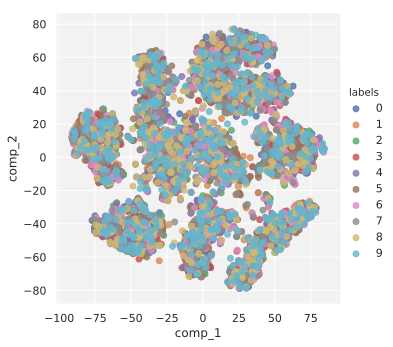

In [145]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
proj = pd.DataFrame(X_tsne)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = y_test
sns.lmplot("comp_1", "comp_2", hue = "labels", data = proj.sample(5000) ,fit_reg=False)

In [144]:
proj.shape

(10000, 2)

In [151]:
data.shape

(60000, 785)

**reshape images so it can be fitted into a neural network**

In [0]:
import tensorflow.keras as keras
from keras import backend as K
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

**normalize Data**

In [15]:
x_train /=255
x_test /=255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [16]:
#one time execution

if conv==False:
  num_classes = 10
  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  conv = True
  print('convertion done')

convertion done


**Model Creation**

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, AveragePooling2D
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(AveragePooling2D())
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())

model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(48, activation=tf.nn.relu))
model.add(Dense(10,activation=tf.nn.softmax))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_1 (Average (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_2 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 28)          4060      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 28)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28)                0         
__________

In [19]:
epochs = 10
batch_size = 10
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 39s 650us/step - loss: 0.2934 - acc: 0.9090 - val_loss: 0.1162 - val_acc: 0.9632
Epoch 2/10
60000/60000 [==============================] - 32s 536us/step - loss: 0.1282 - acc: 0.9611 - val_loss: 0.0793 - val_acc: 0.9764
Epoch 3/10
60000/60000 [==============================] - 32s 539us/step - loss: 0.0985 - acc: 0.9706 - val_loss: 0.0791 - val_acc: 0.9770
Epoch 4/10
60000/60000 [==============================] - 32s 539us/step - loss: 0.0821 - acc: 0.9749 - val_loss: 0.0606 - val_acc: 0.9813
Epoch 5/10
60000/60000 [==============================] - 32s 534us/step - loss: 0.0723 - acc: 0.9778 - val_loss: 0.0665 - val_acc: 0.9789
Epoch 6/10
60000/60000 [==============================] - 33s 545us/step - loss: 0.0647 - acc: 0.9801 - val_loss: 0.0613 - val_acc: 0.9827
Epoch 7/10
60000/60000 [==============================] - 31s 522us/

9


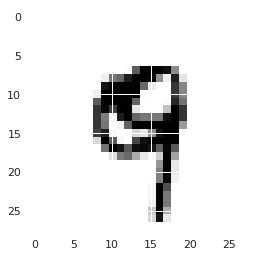

In [20]:
image_index = 4444
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
pred = model.predict(x_test[image_index].reshape(1, 28, 28, 1))
print(pred.argmax())

In [36]:
from collections import Counter
f_index = []
f_prediction = []
y_pred = []
print(' predected value vs real value')
for i in range(len(x_test)):
    pred = model.predict(x_test[i].reshape(1, 28, 28, 1))
    y_pred.append(pred.argmax())
    if  pred.argmax() != list(y_test[i]).index(1):
        f_index.append(i)
        f_prediction.append(pred.argmax())
print(len(f_index))
print(len(f_prediction))
print(len(y_pred))

 predected value vs real value
171
171
10000


In [0]:
y_true = np.argmax(y_test,axis = 1) 

In [39]:
y_true

array([7, 2, 1, ..., 4, 5, 6])

[Text(0, 0.5, 'count false prediction'), Text(0.5, 0, 'digits')]

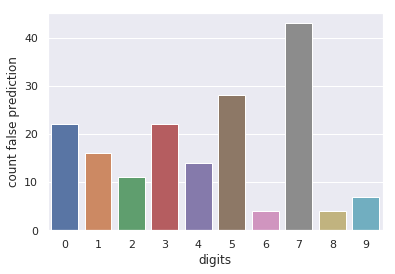

In [26]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x=f_prediction)
ax.set(xlabel= 'digits', ylabel='count false prediction')

`print value where the model fail to recognise the digit`

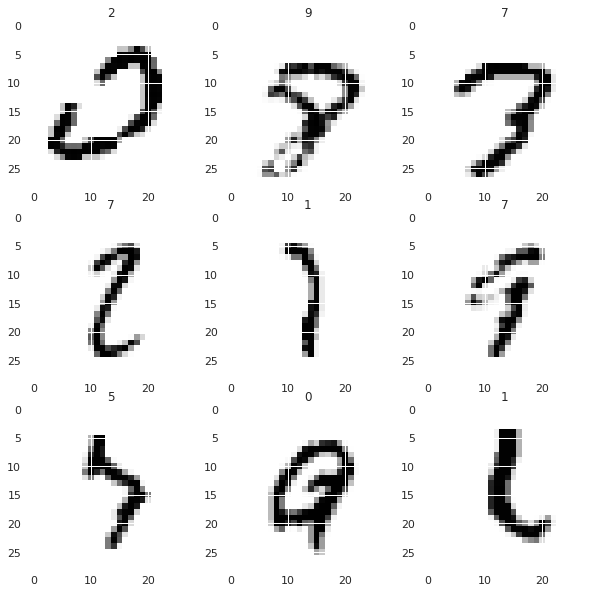

In [27]:
import random
number_samples = 9 #multple of three
samples =  random.sample(f_index, number_samples)
fig = plt.figure(figsize=(10, 10))
c = 1
for i in range(number_samples//3):
  for j in range(3):
    plt.subplot(3, 3, c)
    plt.imshow(x_test[samples[c-1]].reshape(28, 28),cmap='Greys')
    pred = model.predict(x_test[samples[c-1]].reshape(1, 28, 28, 1))
    plt.title(pred.argmax())
    c += 1
plt.show()
#plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
#pred = model.predict(x_test[image_index].reshape(1, 28, 28, 1))
#print(pred.argmax())




```
# confusion matrix
```



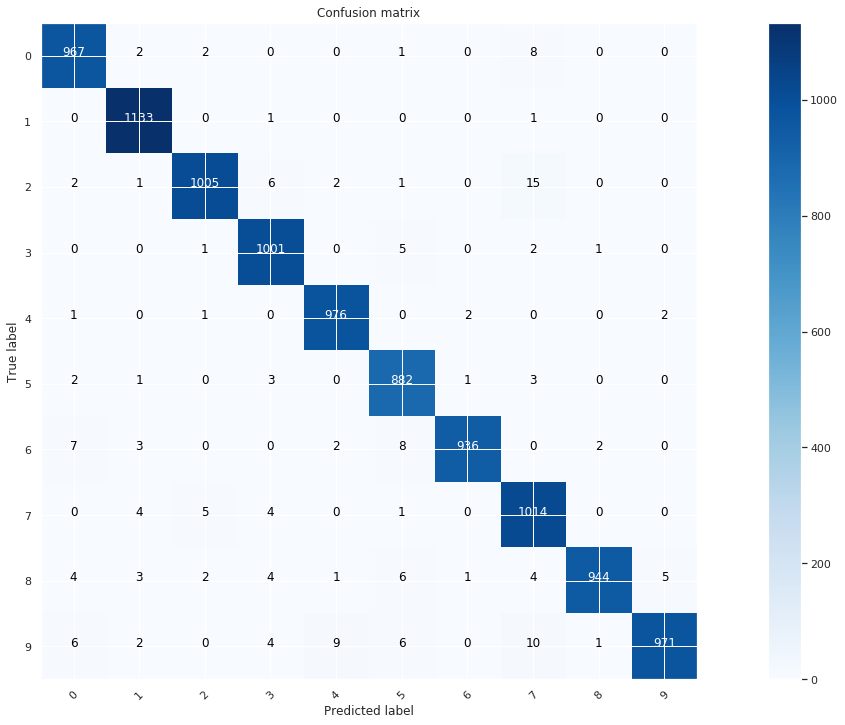

In [42]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (20, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

confusion_mtx = confusion_matrix(y_true, y_pred) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

**Explain model decision using shap**

In [43]:
! pip install shap
import shap

     |████████████████████████████████| 235kB 9.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/93/3f/4a/331cf71b5043416aeba0df795e7c204c7ad277673f1938d11b
Successfully built shap


In [0]:
# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)


**succeed**

In [0]:
shap_values = e.shap_values(x_test[1:6])


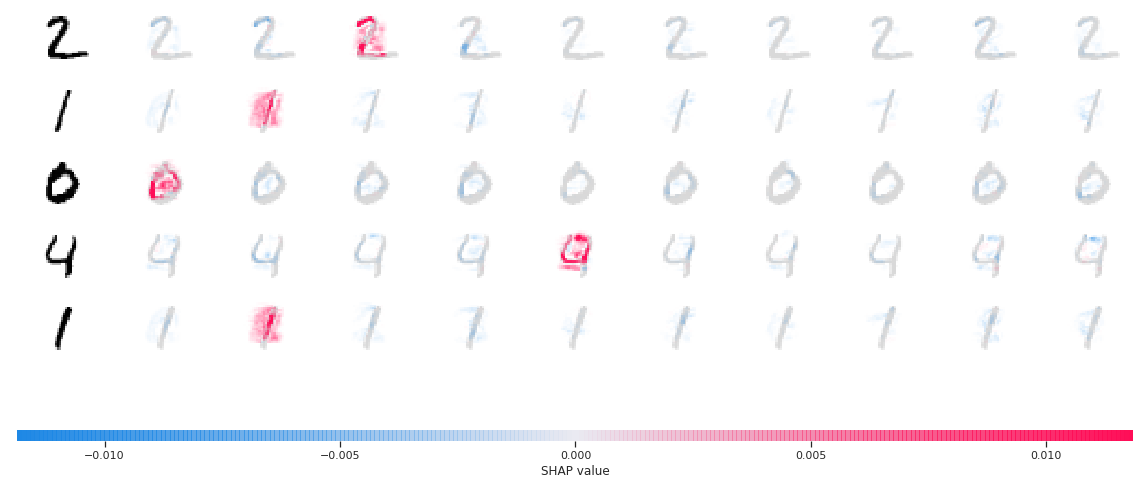

In [46]:
# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:6])

**Failed**

In [0]:
samples = random.sample(f_index, 5)
shap_values = e.shap_values(x_test[samples])

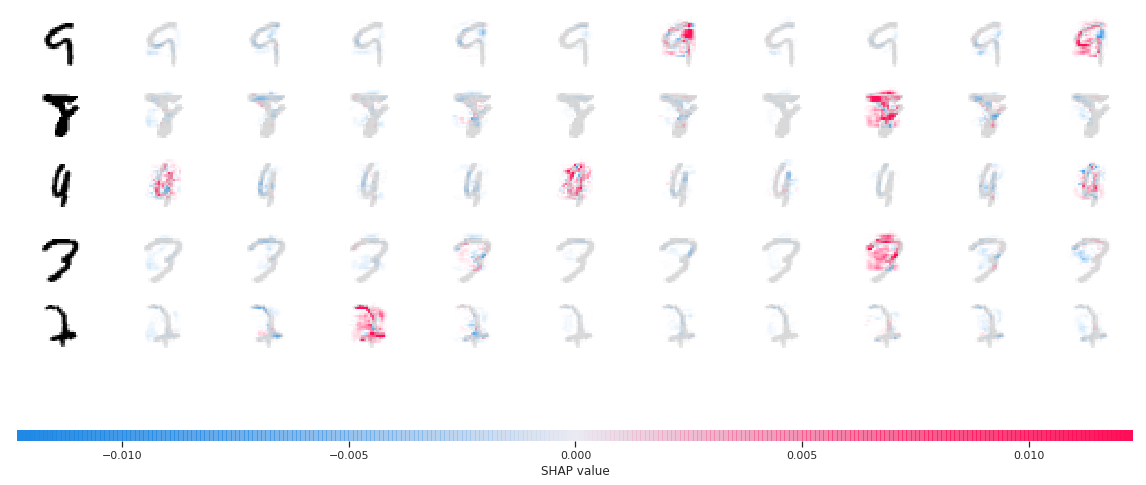

In [48]:
# plot the feature attributions
shap.image_plot(shap_values, -x_test[samples])

**another network**

In [65]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, AveragePooling2D, MaxPool2D, BatchNormalization

model1 = Sequential()

model1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', 
                 input_shape = input_shape, name = "CONV_1"))
model1.add(BatchNormalization(name = "BN_1"))
model1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', name = "CONV_2"))
model1.add(BatchNormalization(name = "BN_2"))
model1.add(MaxPool2D(pool_size=(2,2), name = "MAXPOOL_1"))
model1.add(Dropout(0.25, name = "DROP_1"))

model1.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu', padding = 'Same', name = "CONV_3"))
model1.add(BatchNormalization(name = "BN_3"))
model1.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu', padding = 'Same', name = "CONV_4"))
model1.add(BatchNormalization(name = "BN_4"))
model1.add(MaxPool2D(pool_size=(2,2), name = "MAXPOOL_2"))
model1.add(Dropout(0.25, name = "DROP_2"))

model1.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu', padding = 'Same', name = "CONV_5"))
model1.add(BatchNormalization(name = "BN_5"))
model1.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu', padding = 'Same', name = "CONV_6"))
model1.add(BatchNormalization(name = "BN_6"))
model1.add(MaxPool2D(pool_size=(2,2), name = "MAXPOOL_3"))
model1.add(Dropout(0.25, name = "DROP_3"))

model1.add(Flatten(name = "FLAT_1"))
model1.add(Dense(256, activation = "relu", name = "FC_1"))
model1.add(BatchNormalization(name = "BN_7"))
model1.add(Dropout(0.3, name = "DROP_4"))
model1.add(Dense(10, activation = "softmax", name = "FC_2"))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 28, 28, 32)        128       
_________________________________________________________________
CONV_2 (Conv2D)              (None, 28, 28, 32)        25632     
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 28, 28, 32)        128       
_________________________________________________________________
MAXPOOL_1 (MaxPooling2D)     (None, 14, 14, 32)        0         
_________________________________________________________________
DROP_1 (Dropout)             (None, 14, 14, 32)        0         
_________________________________________________________________
CONV_3 (Conv2D)              (None, 14, 14, 64)        18496     
__________

In [0]:
from sklearn.model_selection import train_test_split
random_seed = 100
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = random_seed)

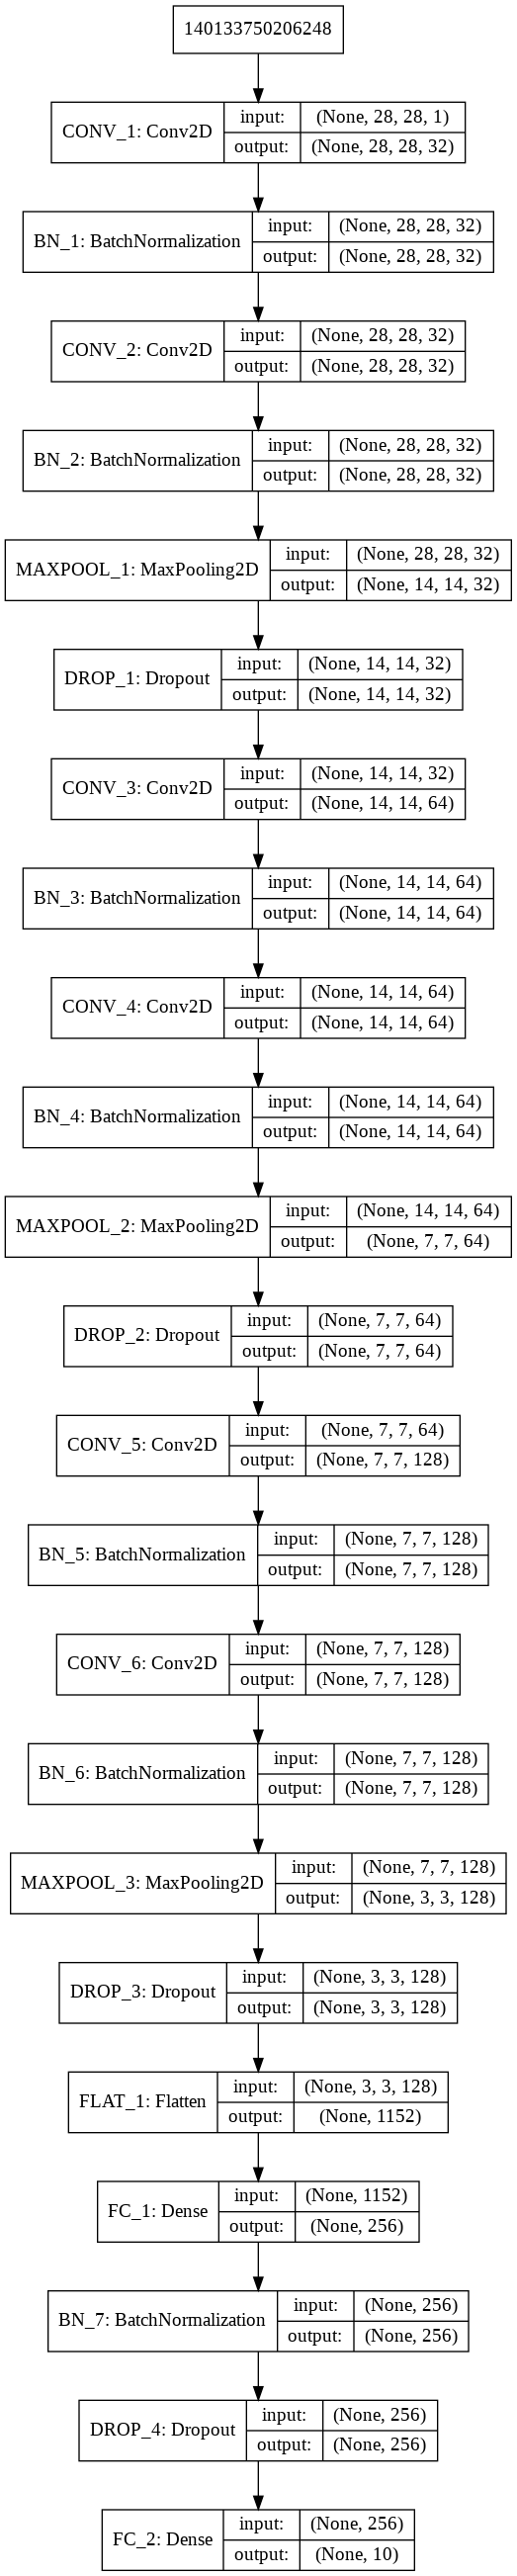

In [67]:
from keras.utils import plot_model
plot_model(model1, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model.png")

In [0]:
from keras.optimizers import RMSprop, adam
optimizer = RMSprop(lr = 0.001, epsilon = 1e-08, decay = 0.0)
model1.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [
    EarlyStopping(
        monitor = 'val_acc', 
        patience = 10,
        mode = 'max',
        verbose = 1),
    ReduceLROnPlateau(
        monitor = 'val_acc', 
        patience = 3, 
        verbose = 1, 
        factor = 0.5, 
        min_lr = 0.00001)]
epochs = 50
batch_size = 64

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range = 10, 
        zoom_range = 0.1, 
        width_shift_range = 0.1,  
        height_shift_range = 0.1)  

datagen.fit(x_train)

In [79]:
his = model1.fit_generator(datagen.flow(x_train, 
                                 y_train, 
                                 batch_size = batch_size),
                    epochs = epochs, 
                    validation_data = (x_val,y_val),
                    verbose = 1, 
                    steps_per_epoch = x_train.shape[0] // batch_size,
                    callbacks = callbacks)

Epoch 1/50
759/759 [==============================] - 19s 25ms/step - loss: 0.2301 - acc: 0.9281 - val_loss: 0.0769 - val_acc: 0.9776
Epoch 2/50
759/759 [==============================] - 18s 23ms/step - loss: 0.0775 - acc: 0.9765 - val_loss: 0.0600 - val_acc: 0.9819
Epoch 3/50
759/759 [==============================] - 18s 23ms/step - loss: 0.0602 - acc: 0.9818 - val_loss: 0.0286 - val_acc: 0.9907
Epoch 4/50
759/759 [==============================] - 17s 22ms/step - loss: 0.0505 - acc: 0.9850 - val_loss: 0.0245 - val_acc: 0.9922
Epoch 5/50
759/759 [==============================] - 17s 22ms/step - loss: 0.0463 - acc: 0.9857 - val_loss: 0.0308 - val_acc: 0.9907
Epoch 6/50
759/759 [==============================] - 17s 22ms/step - loss: 0.0413 - acc: 0.9872 - val_loss: 0.0183 - val_acc: 0.9935
Epoch 7/50
759/759 [==============================] - 18s 24ms/step - loss: 0.0401 - acc: 0.9883 - val_loss: 0.0262 - val_acc: 0.9922
Epoch 8/50
759/759 [==============================] - 17s 22ms

In [87]:
score = model1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.01147232652479165
Test accuracy: 0.9967


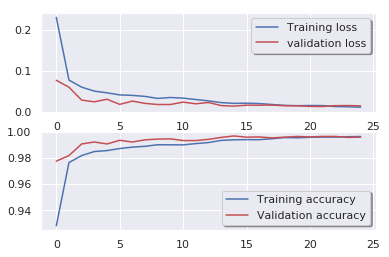

In [80]:
fig, ax = plt.subplots(2,1)
ax[0].plot(his.history['loss'], color = 'b', label = "Training loss")
ax[0].plot(his.history['val_loss'], color = 'r', label = "validation loss" ,axes = ax[0])
legend = ax[0].legend(loc = 'best', shadow = True)

ax[1].plot(his.history['acc'], color = 'b', label = "Training accuracy")
ax[1].plot(his.history['val_acc'], color = 'r',label = "Validation accuracy")
legend = ax[1].legend(loc = 'best', shadow = True)

In [84]:
from collections import Counter
f_index = []
f_prediction = []
y_pred = []
print(' predected value vs real value')
for i in range(len(x_test)):
    pred = model1.predict(x_test[i].reshape(1, 28, 28, 1))
    y_pred.append(pred.argmax())
    if  pred.argmax() != list(y_test[i]).index(1):
        f_index.append(i)
        f_prediction.append(pred.argmax())
print(len(f_index))
print(len(f_prediction))
print(len(y_pred))

 predected value vs real value
33
33
10000


[Text(0, 0.5, 'count false prediction'), Text(0.5, 0, 'digits')]

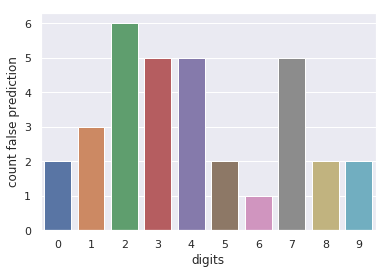

In [85]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x=f_prediction)
ax.set(xlabel= 'digits', ylabel='count false prediction')

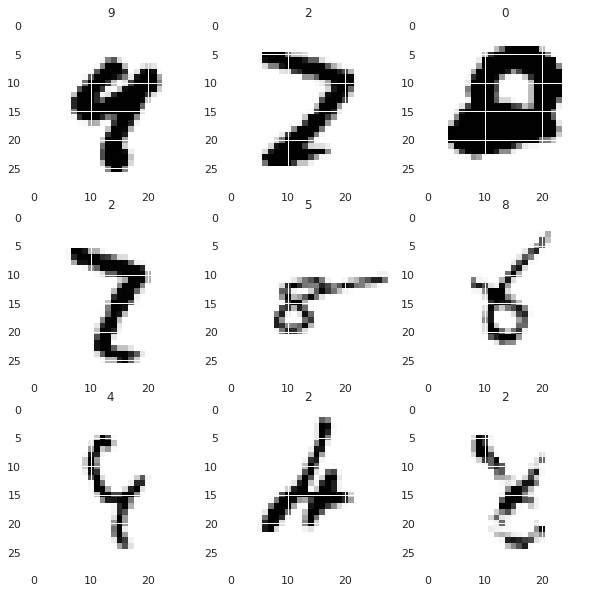

In [86]:
import random
number_samples = 9 #multple of three
samples =  random.sample(f_index, number_samples)
fig = plt.figure(figsize=(10, 10))
c = 1
for i in range(number_samples//3):
  for j in range(3):
    plt.subplot(3, 3, c)
    plt.imshow(x_test[samples[c-1]].reshape(28, 28),cmap='Greys')
    pred = model1.predict(x_test[samples[c-1]].reshape(1, 28, 28, 1))
    plt.title(pred.argmax())
    c += 1
plt.show()

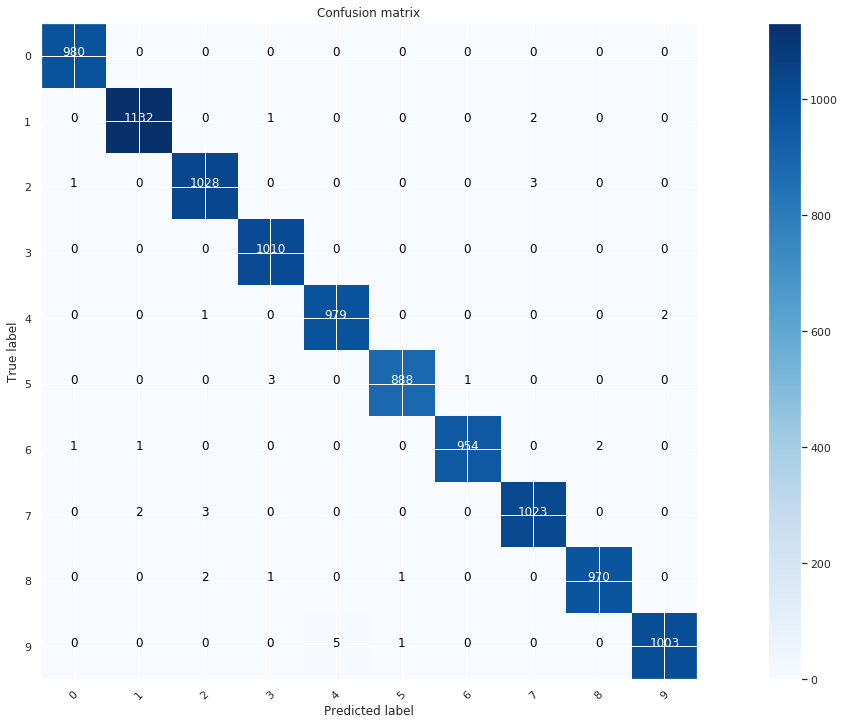

In [93]:
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [0]:
# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on three images
e = shap.DeepExplainer(model1, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)


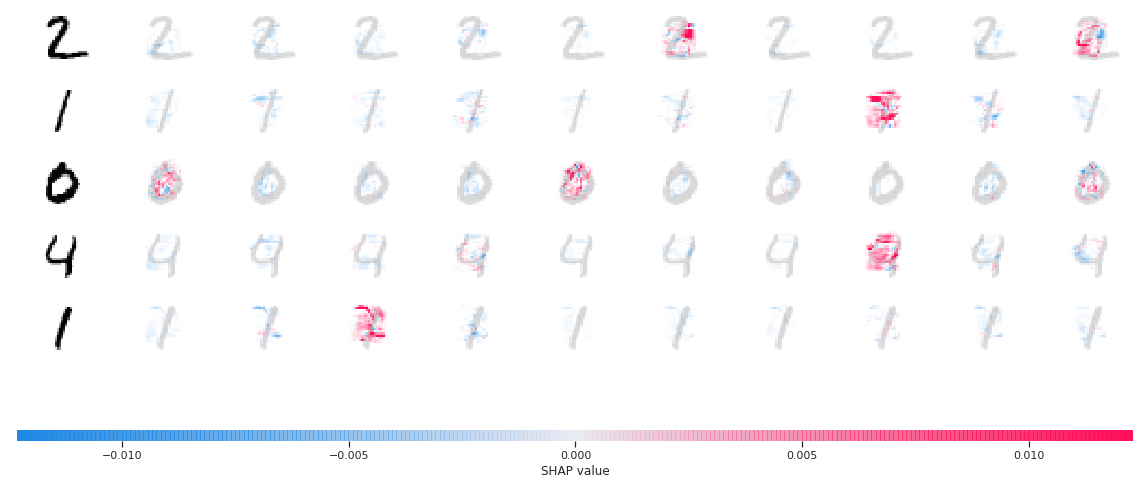

In [89]:
# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:6])

In [0]:
samples = random.sample(f_index, 5)
shap_values = e.shap_values(x_test[samples])

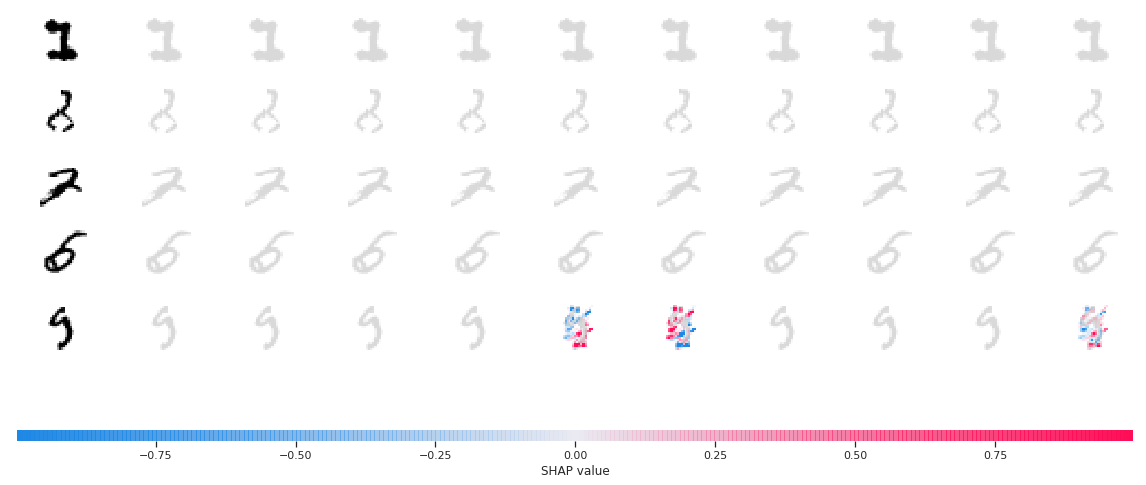

In [91]:
# plot the feature attributions
shap.image_plot(shap_values, -x_test[samples])